In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os

import scipy
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [2]:
seed = 42
no_users = 20 
lambda_logistic = 1e-3

In [3]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.size)
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

In [4]:
def loss(w, A, b, l2):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg

In [5]:
def gradient(w, A, b, l2):
    m = A.shape[0]
    z = b * np.dot(A, w)
    tmp0 = np.minimum(z, 0)
    tmp1 = np.exp(tmp0 - z) / ((np.exp(tmp0) + np.exp(tmp0 - z)))
    tmp2 = - tmp1 * b
    res = np.dot(A.T, tmp2) / m + l2 * w
    return res

In [6]:
def hessian(w, A, b, l2):
    Aw = A @ w
    activation = scipy.special.expit(Aw)
    weights = activation * (1-activation)
    A_weighted = np.multiply(A.T, weights)
    return A_weighted@A/A.shape[0] + l2*np.eye(A.shape[1])

In [7]:
def generate_graph(n, seed):
    """Generate a random connected graph"""
    while True:
        g = nx.generators.random_graphs.binomial_graph(n, 0.4, seed = seed) 
        # g = nx.random_geometric_graph(n, 0.4, seed = seed)
        #g = nx.grid_2d_graph(int(n/5), int(n/5))
        if nx.algorithms.components.is_connected(g):
            return g

In [8]:
def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)

In [9]:
def metropolis_weights(Adj):
    N = np.shape(Adj)[0]
    degree = degrees(Adj)
    W = np.zeros([N, N])
    for i in range(N):
        N_i = np.nonzero(Adj[np.array([i]), :])[1]  # Fixed Neighbors
        for j in N_i:
            W[i, j] = 1/(1+np.max([degree[i], degree[j]]))
        W[i, i] = 1 - np.sum(W[i, :])
    return W

83
20


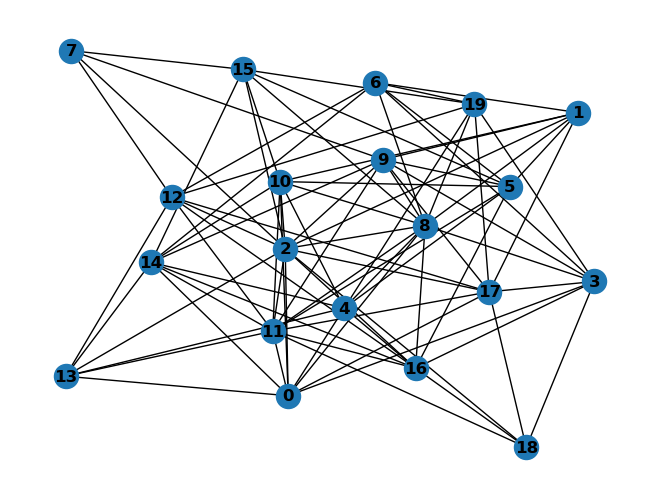

In [10]:
G = generate_graph(no_users, seed)
adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
comm_matrix = metropolis_weights(adjacency_matrix)
print(G.number_of_edges())
print(G.number_of_nodes())
nx.draw(G, with_labels=True, font_weight='bold')

In [11]:
X = np.load('X.npy')
y = np.load('y.npy').ravel()

num_feature = X.shape[1] #+ 1 #+1 for bias

In [12]:
X, y = random_split(X, y, no_users, seed)

theta_old = [np.zeros(num_feature) for _ in range(no_users)]
theta_new = [np.zeros(num_feature) for _ in range(no_users)] # initial model

d = [np.zeros(num_feature) for _ in range(no_users)] # direction

grad_old = [np.zeros(num_feature) for _ in range(no_users)] # old grads
grad_new = [np.zeros(num_feature) for _ in range(no_users)] # new grdas


Hess_old = [np.zeros([num_feature, num_feature]) for _ in range(no_users)] # old hessians
Hess_new = [np.zeros([num_feature, num_feature]) for _ in range(no_users)] # new hessians


In [13]:
# Optimal objective function, i.e., f(x*)
obj0 = 0.02540046699809508 # phishing dataset

In [14]:
n_iters = 200
eps = 0.8 #1.2
alpha = 0.8 #1.1
losses_newton_tracking = []
accuracies_newton_tracking = []
op_gap_newton_tracking = np.zeros(shape=[n_iters])

# Inintialization of u0
for i in range(no_users):
  grad_old[i] = gradient(theta_old[i], X[i], y[i], lambda_logistic)
  Hess_old[i] = hessian(theta_old[i], X[i], y[i], lambda_logistic)
  d[i] = np.matmul(np.linalg.inv(Hess_old[i] + eps * np.eye(num_feature)),grad_old[i])


for k in range(n_iters):
    for i in range(no_users):
        theta_new[i] = theta_old[i] - d[i]
        grad_new[i] = gradient(theta_new[i], X[i], y[i], lambda_logistic)
        Hess_new[i] = hessian(theta_new[i], X[i], y[i], lambda_logistic)

    for i in range(no_users):
      theta_old_neighbors_sum = np.zeros(num_feature)
      theta_new_neighbors_sum = np.zeros(num_feature)
      theta_old_neighbors_sum = np.add(theta_old_neighbors_sum, comm_matrix[i, i] * theta_old[i])
      theta_new_neighbors_sum = np.add(theta_new_neighbors_sum, comm_matrix[i, i] * theta_new[i])
      for j in G.neighbors(i):
          theta_old_neighbors_sum = np.add(theta_old_neighbors_sum, comm_matrix[i, j] * theta_old[j])
          theta_new_neighbors_sum = np.add(theta_new_neighbors_sum, comm_matrix[i, j] * theta_new[j])
      
      # direction update
      d[i] = np.matmul(np.linalg.inv(Hess_new[i] + eps * np.eye(num_feature)),\
                                  np.matmul(Hess_old[i] + eps * np.eye(num_feature), d[i]) + \
                                            grad_new[i] - grad_old[i] + 2 * alpha * (theta_new[i] - theta_new_neighbors_sum) - \
                       alpha * (theta_old[i] - theta_old_neighbors_sum))
      
    
        
    # Performance Check
    theta_avg = 1/no_users*sum(theta_new)
    
    loss_newton_tracking = np.mean([loss(theta_avg, X[i], y[i], lambda_logistic) for i in range(no_users)])
    losses_newton_tracking.append(loss_newton_tracking)
    
    op_gap_newton_tracking[k] = np.abs(losses_newton_tracking[-1] - obj0)

    # Updating the old copies 
    for i in range(no_users):
      theta_old[i] = theta_new[i]
      grad_old[i] = grad_new[i]
      Hess_old[i] = Hess_new[i]

# Optimality Gap

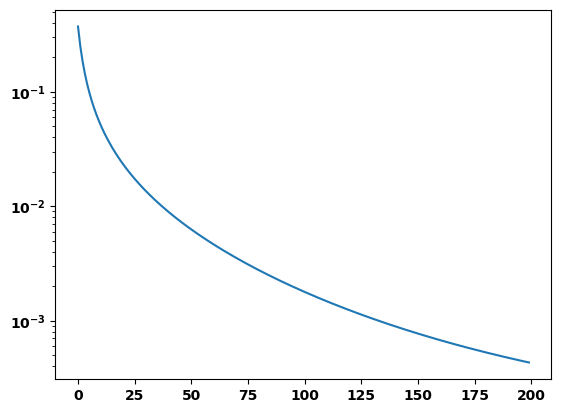

In [15]:
import matplotlib.pyplot as plt
plt.semilogy(op_gap_newton_tracking)
np.save('op_gap_newton_tracking', op_gap_newton_tracking)

In [16]:
op_gap_newton_tracking[75]

0.0030988788960773887